# RQ2 - What is the scope of the software artifacts?

In [1]:
import pandas as pd
import numpy as np
from upsetplot import plot
from matplotlib import pyplot
from upsetplot import from_contents
from matplotlib import pyplot as plt
from upsetplot import UpSet
import helpers as helpers

path = '../data/studies-and-artifacts.json'

artifacts_df = pd.read_json(path, orient='index')

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

def add_list_to_dict(dict_variable = None, key = None, items_list = None):
  if key in dict_variable.keys():
    dict_variable[key].extend(items_list)
    dict_variable[key] = list(set(dict_variable[key]))
  else:
    dict_variable[key] = items_list
  return dict_variable

### TDMA and TD Types Total

In [2]:
#Total x TD TDMA
to_1D(artifacts_df['tdma']).value_counts()

identification                  111
measurement                      26
prioritization                    9
monitoring                        8
repayment                         7
representation/documentation      3
prevention                        2
communication                     1
Name: count, dtype: int64

In [3]:
#Total x TD Type
types = to_1D(artifacts_df['td_type']).value_counts()

### TD Activities

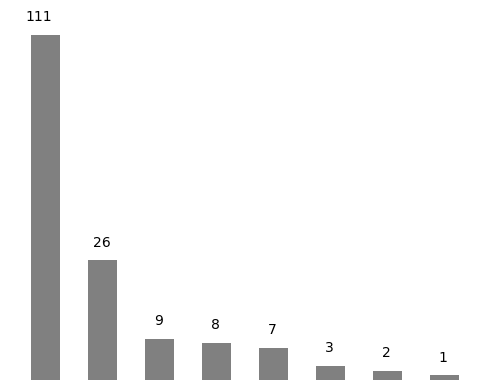

In [4]:
tdma = to_1D(artifacts_df['tdma']).value_counts().sort_values(ascending=False)

width = 0.25
x_pos = [0 + (2* x * width) for x in range(len(tdma))]

plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(layout='tight')
ax.bar(x_pos, height=tdma, width = width, color = 'grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

scale = 75

for index, value in enumerate(tdma):
    if value > 100:
        factor = 0.7
    elif value > 10:
        factor = 0.32
    else:
        factor = 0.2
        
    ax.text(x_pos[index] - factor * width, value + 3 if value <= scale else scale + 3,
             str(value))

ax.set_ylim([0,scale])
ax.set_yticks([])
ax.set_xticks([])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('../figures/rq2-tdma.pdf', bbox_inches='tight')

In [5]:
tdma = to_1D(artifacts_df['tdma']).value_counts().sort_values(ascending = False).index.to_list()
columns = ['id']
columns.extend(tdma)

rows = []

for i in artifacts_df.index:
  r = []
  r.append(i)
  for a in tdma:
    if a in artifacts_df['tdma'][i]:
      r.append(True)
    else:
      r.append(False)
  rows.append(r)

uppset_tdma = pd.DataFrame(rows, columns=columns)

In [6]:
#Number of artifacts that automate a single TD activity
len([x for x in artifacts_df['tdma'].str.len() if x == 1])

90

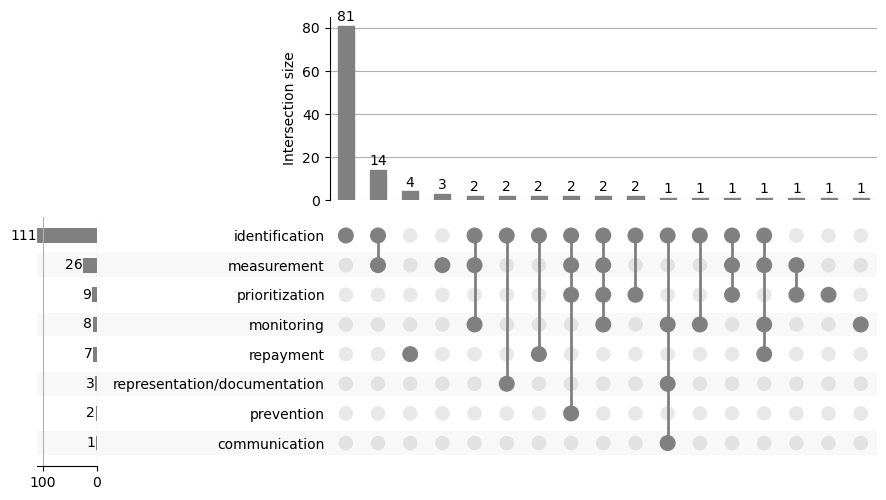

In [7]:
artifacts_tdma = {}
for i in tdma:
  ids = uppset_tdma.loc[uppset_tdma[i] == True]['id'].to_list()
  artifacts_tdma = add_list_to_dict(dict_variable = artifacts_tdma,
                                         key = i,
                                         items_list = ids)

helpers.plot_upset(items_dict = artifacts_tdma, element_size = 30, color = 'grey', output_name = 'rq2-upset-tdma')

### TD Types

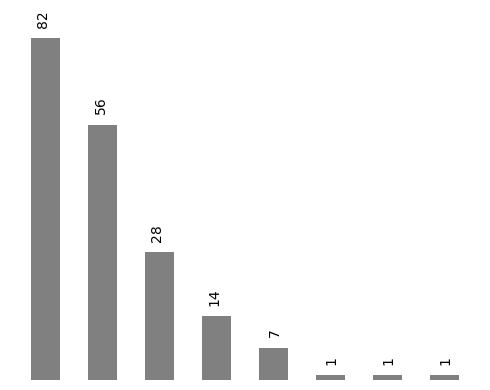

In [8]:
td_types = to_1D(artifacts_df['td_type']).value_counts().sort_values(ascending = False).drop('')

width = 0.25
x_pos = [0 + (2* x * width) for x in range(len(td_types))]

plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(layout='tight')
ax.bar(x_pos, height=td_types, width = width, color = 'grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

scale = 75

for index, value in enumerate(td_types):
    if value > 100:
        factor = 0.5
    elif value > 10:
        factor = 0.32
    else:
        factor = 0.2
        
    ax.text(x_pos[index] - factor * width, value + 3 if value <= scale else scale + 3,
             str(value), rotation = 90)

ax.set_ylim([0,scale])
ax.set_yticks([])
ax.set_xticks([])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('../figures/rq2-td-types.pdf', bbox_inches='tight')

In [9]:
#Collecting the list of TD Types
td_types = to_1D(artifacts_df['td_type']).value_counts().sort_values(ascending=False).drop('').index.to_list()


columns = ['id']
columns.extend(td_types)

rows = []

for i in artifacts_df.index:
  r = []
  r.append(i)
  for a in td_types:
    if a in artifacts_df['td_type'][i]:
      r.append(True)
    else:
      r.append(False)
  rows.append(r)

uppset_td_types = pd.DataFrame(rows, columns=columns)

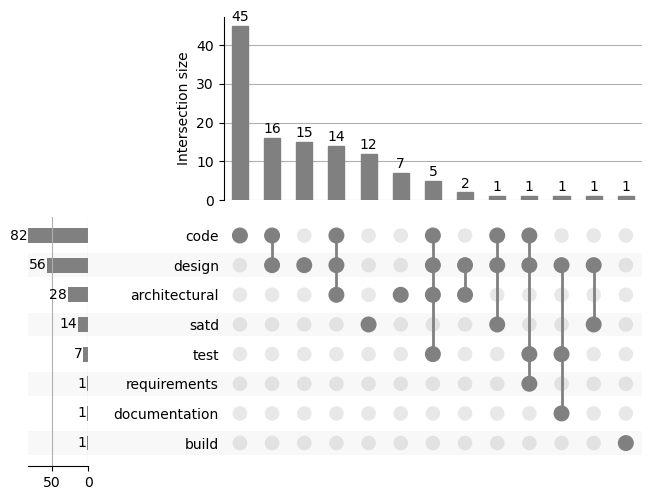

In [10]:
artifacts_tdt = {}
for i in td_types:
  ids = uppset_td_types.loc[uppset_td_types[i] == True]['id'].to_list()
  artifacts_tdt = add_list_to_dict(dict_variable = artifacts_tdt,
                                         key = i,
                                         items_list = ids)
    
helpers.plot_upset(items_dict = artifacts_tdt, element_size = 30, color = 'grey', output_name = 'rq2-upset-td-types')

## TD Activities x TD Types

In [11]:
merged_df = uppset_td_types.merge(uppset_tdma, left_on='id', right_on='id')

In [12]:
tdma_tdt = {}

for tda in tdma:
    tdma_tdt[tda] = {}
    for tdt in td_types:
        tdma_tdt[tda][tdt] = len(merged_df.loc[(merged_df[tdt] == True) & (merged_df[tda] == True)])

In [13]:
#Number of artifacts per TDMA and TD Type
columns = ['type']
columns.extend(tdma)

rows = []
for tdt in td_types:
    r = []
    r.append(tdt)
    for k, tda in tdma_tdt.items():
        r.append(tda[tdt])
    rows.append(r)
new_df = pd.DataFrame(rows, columns=columns)    
new_df.to_csv('../data/rq2-td-types-per-tdma.csv')